## Timeline Analysis

In [1]:
import os
import subprocess
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F

from pyspark.sql.types import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# import pyspark functions and data types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col, element_at, count, countDistinct, avg, split, array_contains, isnan, when

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
gcs_folder = 'gs://msca-bdp-students-bucket/shared_data/esmyslovskikh/whole_df.parquet/'

df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .parquet(gcs_folder)

In [5]:
#df.cache()

In [6]:
#df.count()

In [7]:
#null_values = df.select([count(when(isnan(c)| col(c).isNull(), c)).alias(c) for c in df.columns])
#null_values.show()

In [8]:
df = df.withColumn("commit_time", col("commit_time").cast("timestamp"))
df = df.withColumn("commit_day", split(df["commit_time"], " ")[0])
# year column
df = df.withColumn("commit_year", split(df["commit_day"], "-")[0])
#df = df.withColumn("commit_time", col("commit_time").cast("int"))
df = df.withColumn("commit_year", col("commit_year").cast(IntegerType()))
#df.cache()

In [9]:
df.printSchema()

root
 |-- commit_author: string (nullable = true)
 |-- commit_time: timestamp (nullable = true)
 |-- repo_name: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- language_new: string (nullable = true)
 |-- license: string (nullable = true)
 |-- commit_day: string (nullable = true)
 |-- commit_year: integer (nullable = true)



In [10]:
#df_pd = df.toPandas()

In [11]:
#df_pd.dtypes

In [12]:
#df_pd['commit_day']= pd.to_datetime(df_pd['commit_day'])
#df_pd['commit_year']= pd.to_numeric(df_pd['commit_year'])

In [13]:
#df_pd.hist(column='commit_day')

#### Remove outliers

In [14]:
# we should filter out all commits before 2008
#df_pd = df_pd.loc[(df_pd['commit_day'] >= '2008-01-01')]

#### Daily commits

In [15]:
#df_pd.hist(column='commit_day')

In [16]:
df = df.filter((df['commit_day'] >= '2008-01-01') & (df['commit_day'] <= '2023-01-01'))
#df.cache()

In [17]:
df_grouped = df.groupby('commit_day').agg(count('*'))
df_grouped = df_grouped.withColumn("commit_day", col("commit_day").cast("timestamp"))
df_grouped = df_grouped.withColumn("count(1)", col("count(1)").cast(IntegerType()))
df_grouped.cache()

commit_day,count(1)
2008-11-19 00:00:00,92
2021-11-03 00:00:00,275
2009-01-04 00:00:00,45
2014-02-22 00:00:00,236
2016-08-17 00:00:00,551
2011-01-29 00:00:00,86
2017-12-05 00:00:00,386
2013-03-14 00:00:00,229
2009-06-23 00:00:00,86
2014-05-27 00:00:00,358


In [18]:
df_grouped.printSchema()

root
 |-- commit_day: timestamp (nullable = true)
 |-- count(1): integer (nullable = false)



In [19]:
df_grouped_pd = df_grouped.toPandas()
daily_commits = pd.DataFrame(df_grouped_pd.groupby(['commit_day']).sum()['count(1)']).reset_index()
daily_commits = daily_commits.rename({"count(1)": "Commits", "commit_day": "Date"}, axis=1)
daily_commits

,Date,Commits
0,2008-01-01,26
1,2008-01-02,42
2,2008-01-03,40
3,2008-01-04,50
4,2008-01-05,35
...,...,...
5443,2022-11-26,6
5444,2022-11-30,1
5445,2022-12-13,1
5446,2022-12-17,1


In [20]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme(style="darkgrid")

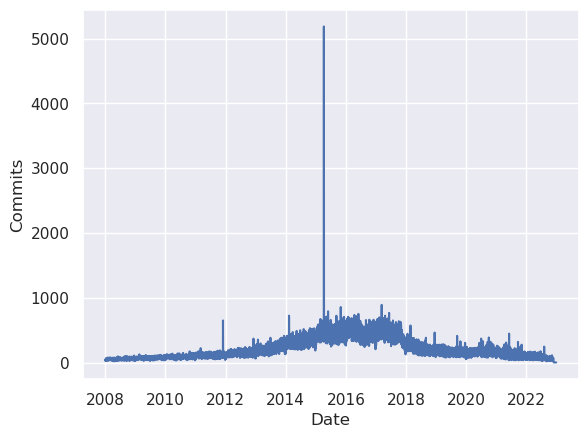

In [21]:
ax = sns.lineplot(x="Date", y="Commits",
             markers=True,
             data=daily_commits)

In [22]:
df_grouped.unpersist()

commit_day,count(1)
2017-12-05 00:00:00,386
2008-12-03 00:00:00,73
2015-05-01 00:00:00,391
2009-06-23 00:00:00,86
2013-03-14 00:00:00,229
2019-08-08 00:00:00,197
2008-11-19 00:00:00,92
2019-08-22 00:00:00,202
2014-05-27 00:00:00,358
2020-02-26 00:00:00,181


#### Yearly commits

In [23]:
df_grouped_y = df.groupby('commit_year').agg(count('*'))
df_grouped_y = df_grouped_y.withColumn("count(1)", col("count(1)").cast(IntegerType()))
df_grouped_y.cache()

commit_year,count(1)
2018,89288
2015,182094
2022,28885
2013,82586
2014,131140
2019,64933
2020,65026
2012,56751
2009,26753
2016,185405


In [24]:
df_grouped_pd_y = df_grouped_y.toPandas()
yearly_commits = pd.DataFrame(df_grouped_pd_y.groupby(['commit_year']).sum()['count(1)']).reset_index()
yearly_commits = yearly_commits.rename({"count(1)": "Commits", "commit_year": "Year"}, axis=1)
yearly_commits

,Year,Commits
0,2008,20896
1,2009,26753
2,2010,33488
3,2011,43784
4,2012,56751
5,2013,82586
6,2014,131140
7,2015,182094
8,2016,185405
9,2017,176405


<AxesSubplot:xlabel='Year', ylabel='Commits'>

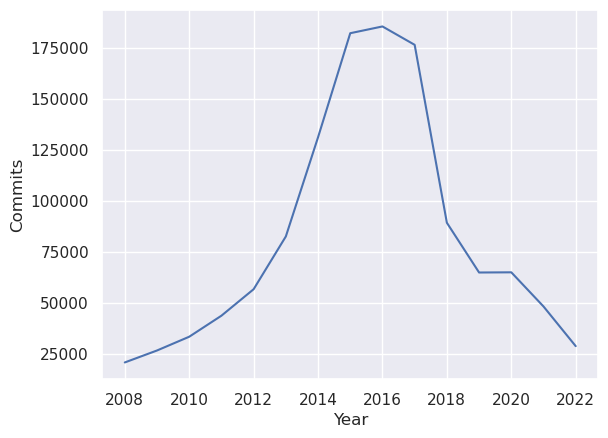

In [25]:
sns.lineplot(x="Year", y="Commits",
             data=yearly_commits)

In [26]:
df_grouped_y.unpersist()

commit_year,count(1)
2018,89288
2015,182094
2022,28885
2013,82586
2014,131140
2019,64933
2020,65026
2012,56751
2009,26753
2016,185405


In [27]:
df.unpersist()

commit_author,commit_time,repo_name,subject,message,language_new,license,commit_day,commit_year
CI Pool Trigger R...,2022-06-11 19:34:05,cloudfoundry/reli...,triggering build ...,triggering build ...,null,apache-2.0,2022-06-11,2022
yoavf,2014-12-07 10:01:00,jokoprastiyo/illu...,esquire: use the ...,esquire: use the ...,CSS,gpl-2.0,2014-12-07,2014
CI Pool Trigger R...,2021-09-19 12:45:21,cloudfoundry/reli...,triggering build ...,triggering build ...,null,apache-2.0,2021-09-19,2021
optimizerbot,2015-01-09 03:47:45,jokoprastiyo/illu...,[Automated] [koi]...,[Automated] [koi]...,CSS,gpl-2.0,2015-01-09,2015
swalker,2012-05-28 00:17:36,cuiqingwei1981/op...,[packages] bluelo...,[packages] bluelo...,ApacheConf,gpl-2.0,2012-05-28,2012
cyrus,2009-01-17 19:09:43,cuiqingwei1981/op...,Switch to LuCI 0.8.4,Switch to LuCI 0.8.4,ApacheConf,gpl-2.0,2009-01-17,2009
thomasguillot,2014-08-19 16:14:13,jokoprastiyo/illu...,Goran: Add site-l...,Goran: Add site-l...,CSS,gpl-2.0,2014-08-19,2014
templth,2009-12-30 14:57:15,sobkowiak/springd...,Added project,Added project ...,C,apache-2.0,2009-12-30,2009
Frazer Clement,2009-12-03 11:39:48,Distrotech/mysql-...,Fix compile break,Fix compile break,Awk,gpl-2.0,2009-12-03,2009
CI Pool Resource,2022-04-14 17:50:51,cloudfoundry/reli...,main/k8s-pool-man...,main/k8s-pool-man...,null,apache-2.0,2022-04-14,2022


In [28]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Fri, 08 March 2024 17:53:00'